In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 27: Official Baseline v1.0
# Notebook: 27_official_baseline_standalone_value.ipynb
#
# Objective:
#   To establish the single, definitive, and immutable performance baseline for
#   all future strategy development. This notebook will execute a methodologically
#   pure backtest of our most robust standalone signal (`Standalone Value`) using
#   a clean engine that contains all critical mechanical fixes but NO risk overlays.
#   The results of this backtest will serve as the "Official Baseline v1.0"
#   against which all subsequent enhancements (e.g., risk overlays, factor
#   enhancements) will be measured.
# ============================================================================
#
# --- STRATEGY & ENGINE SPECIFICATION ---
#
# *   **Strategy**: `A_Standalone_Value`
#     -   **Backtest Period**: 2016-03-01 to 2025-07-28 (Full Period)
#     -   **Signal**: `Value_Composite` from the `qvm_v2.0_enhanced` engine.
#
# *   **Execution Engine**: `PortfolioEngine_v3.1` (from Phase 23)
#     -   **P0 Fix**: Correct turnover calculation (`turnover / 2`).
#     -   **P1 Fixes**: Hybrid portfolio construction (Fixed-N for small universes,
#       Percentile for large) and z-score safeguards.
#     -   **EXCLUDED**: No volatility targeting, no regime filters, no stop-losses.
#       The portfolio is fully invested at all times.
#
# --- METHODOLOGY WORKFLOW ---
#
# 1.  **Setup & Configuration**: Define the single configuration for the baseline run.
# 2.  **Data Ingestion**: Load all required data for the full 2016-2025 period.
# 3.  **Engine Definition**: Define the clean `PortfolioEngine_v3.1` class.
# 4.  **Backtest Execution**: Run the full-period backtest.
# 5.  **Performance Analysis & Reporting**:
#     -   Generate a full institutional tearsheet with a **CORRECTLY ALIGNED**
#       benchmark, ensuring both strategy and index start their cumulative
#       return calculation from the date of the first trade.
#     -   Produce the final, official performance metrics table.
#
# --- DATA DEPENDENCIES ---
#
# *   **Database**: `alphabeta` (Production)
# *   **Tables**:
#     -   `factor_scores_qvm` (strategy_version='qvm_v2.0_enhanced')
#     -   `equity_history`
#     -   `vcsc_daily_data_complete`
#
# --- EXPECTED OUTPUTS ---
#
# 1.  **Primary Deliverable**: The Official Baseline v1.0 Tearsheet. This chart
#     must show a perfectly aligned benchmark and a complete drawdown curve.
# 2.  **Secondary Deliverable**: The Official Baseline v1.0 performance table.
#     These metrics (Sharpe, Max DD, etc.) will become the formal hurdles that
#     all future strategy improvements must beat.
#

In [1]:
# ============================================================================
# CELL 2: SETUP & CONFIGURATION
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# --- Add Project Root to Python Path (Corrected Logic) ---
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.universe.constructors import get_liquid_universe_dataframe
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    raise

# --- Official Baseline v1.0 Configuration ---
# This is the single source of truth for the baseline strategy.
BASELINE_CONFIG = {
    # --- Backtest Parameters ---
    "strategy_name": "Official_Baseline_v1.0_Value",
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q", # Quarterly
    "transaction_cost_bps": 30, # Flat 30bps for simplicity in baseline

    # --- Universe Construction ---
    "universe": {
        "lookback_days": 63,
        "adtv_threshold_bn": 10.0,
        "top_n": 200,
        "min_trading_coverage": 0.6,
    },

    # --- Factor & Signal Generation ---
    "signal": {
        "factors_to_combine": {
            'Value_Composite': 1.0
        },
        "db_strategy_version": "qvm_v2.0_enhanced"
    },

    # --- Portfolio Construction (Hybrid Method from v3.1) ---
    "portfolio": {
        "construction_method": "hybrid",
        "portfolio_size_small_universe": 20, # Fixed-N for small universes
        "selection_percentile": 0.8, # Top 20% for large universes
    }
}

print("\n⚙️  Official Baseline v1.0 Configuration Loaded:")
print(f"   - Strategy: {BASELINE_CONFIG['strategy_name']}")
print(f"   - Period: {BASELINE_CONFIG['backtest_start_date']} to {BASELINE_CONFIG['backtest_end_date']}")
print(f"   - Engine Logic: P0 (Turnover) + P1 (Hybrid Portfolio) fixes included.")
print(f"   - Risk Overlay: NONE (Fully invested)")

# --- Database Connection ---
def create_db_connection(project_root_path: Path):
    """Establishes a SQLAlchemy database engine connection."""
    try:
        config_path = project_root_path / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        
        connection_string = (
            f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
            f"@{db_config['host']}/{db_config['schema_name']}"
        )
        engine = create_engine(connection_string, pool_pre_ping=True)
        
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine

    except Exception as e:
        print(f"❌ FAILED to connect to the database.")
        print(f"   - Config path checked: {config_path}")
        print(f"   - Error: {e}")
        return None

# Create the engine for this session
engine = create_db_connection(project_root)

if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.")

✅ Successfully imported production modules.
   - Project Root set to: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project

⚙️  Official Baseline v1.0 Configuration Loaded:
   - Strategy: Official_Baseline_v1.0_Value
   - Period: 2016-03-01 to 2025-07-28
   - Engine Logic: P0 (Turnover) + P1 (Hybrid Portfolio) fixes included.
   - Risk Overlay: NONE (Fully invested)

✅ Database connection established successfully to schema 'alphabeta'.


In [2]:
# ============================================================================
# CELL 3: DATA INGESTION FOR FULL BACKTEST PERIOD
# ============================================================================

def load_all_data_for_backtest(config: dict, db_engine):
    """
    Loads all necessary data (factors, prices, benchmark) for the
    specified backtest period.
    """
    start_date = config['backtest_start_date']
    end_date = config['backtest_end_date']
    db_version = config['signal']['db_strategy_version']
    
    # Add a buffer to the start date for rolling calculations
    buffer_start_date = pd.Timestamp(start_date) - pd.DateOffset(months=3)
    
    print(f"📂 Loading all data for period: {buffer_start_date.date()} to {end_date}...")

    db_params = {
        'start_date': buffer_start_date,
        'end_date': pd.Timestamp(end_date),
        'strategy_version': db_version
    }

    # 1. Factor Scores
    print("   - Loading factor scores...")
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data = pd.read_sql(factor_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(factor_data):,} factor observations.")

    # 2. Price Data
    print("   - Loading price data...")
    price_query = text("""
        SELECT date, ticker, close 
        FROM equity_history
        WHERE date BETWEEN :start_date AND :end_date
    """)
    price_data = pd.read_sql(price_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(price_data):,} price observations.")

    # 3. Benchmark Data
    print("   - Loading benchmark data (VN-Index)...")
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data = pd.read_sql(benchmark_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(benchmark_data):,} benchmark observations.")

    # --- Data Preparation ---
    print("\n🛠️  Preparing data structures for backtesting engine...")

    # Create returns matrix
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')

    # Create benchmark returns series
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')

    print("   ✅ Data preparation complete.")
    return factor_data, daily_returns_matrix, benchmark_returns

# Execute the data loading
try:
    factor_data_raw, daily_returns_matrix, benchmark_returns = load_all_data_for_backtest(BASELINE_CONFIG, engine)
    print("\n✅ All data successfully loaded and prepared for the backtest.")
    print(f"   - Factor Data Shape: {factor_data_raw.shape}")
    print(f"   - Returns Matrix Shape: {daily_returns_matrix.shape}")
    print(f"   - Benchmark Returns: {len(benchmark_returns)} days")
except Exception as e:
    print(f"❌ ERROR during data ingestion: {e}")
    raise

📂 Loading all data for period: 2015-12-01 to 2025-07-28...
   - Loading factor scores...
     ✅ Loaded 1,567,488 factor observations.
   - Loading price data...
     ✅ Loaded 1,623,168 price observations.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 2,411 benchmark observations.

🛠️  Preparing data structures for backtesting engine...
   ✅ Data preparation complete.

✅ All data successfully loaded and prepared for the backtest.
   - Factor Data Shape: (1567488, 5)
   - Returns Matrix Shape: (2408, 728)
   - Benchmark Returns: 2411 days


In [3]:
# ============================================================================
# CELL 4: BASELINE PORTFOLIO ENGINE (v3.1 LOGIC)
# ============================================================================

class BaselinePortfolioEngine:
    """
    A clean backtesting engine implementing the logic from PortfolioEngine_v3.1.
    This engine includes P0 (turnover) and P1 (hybrid portfolio construction)
    fixes but contains NO risk overlays. It is used to establish the official
    performance baseline of the fully-invested strategy.
    """
    def __init__(self, config: dict, factor_data: pd.DataFrame, returns_matrix: pd.DataFrame,
                 benchmark_returns: pd.Series, db_engine):
        
        self.config = config
        self.engine = db_engine
        
        # Slice data to the exact backtest window
        start = pd.Timestamp(config['backtest_start_date'])
        end = pd.Timestamp(config['backtest_end_date'])
        
        self.factor_data_raw = factor_data[factor_data['date'].between(start, end)].copy()
        self.daily_returns_matrix = returns_matrix.loc[start:end].copy()
        self.benchmark_returns = benchmark_returns.loc[start:end].copy()
        
        print("✅ BaselinePortfolioEngine initialized.")
        print(f"   - Strategy: {config['strategy_name']}")
        print(f"   - Period: {self.daily_returns_matrix.index.min().date()} to {self.daily_returns_matrix.index.max().date()}")

    def run_backtest(self) -> (pd.Series, pd.DataFrame):
        """Executes the full backtesting pipeline."""
        print("\n🚀 Starting baseline backtest execution...")
        
        rebalance_dates = self._generate_rebalance_dates()
        daily_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        net_returns = self._calculate_net_returns(daily_holdings)
        
        print("✅ Baseline backtest execution complete.")
        return net_returns, diagnostics

    def _generate_rebalance_dates(self) -> list:
        """Generates quarterly rebalance dates based on actual trading days."""
        all_trading_dates = self.daily_returns_matrix.index
        rebal_dates_calendar = pd.date_range(
            start=self.config['backtest_start_date'],
            end=self.config['backtest_end_date'],
            freq=self.config['rebalance_frequency']
        )
        actual_rebal_dates = [all_trading_dates[all_trading_dates.searchsorted(d, side='left')-1] for d in rebal_dates_calendar if d >= all_trading_dates.min()]
        print(f"   - Generated {len(actual_rebal_dates)} quarterly rebalance dates.")
        return sorted(list(set(actual_rebal_dates)))

    def _run_backtesting_loop(self, rebalance_dates: list) -> (pd.DataFrame, pd.DataFrame):
        """The core loop for portfolio construction at each rebalance date."""
        daily_holdings = pd.DataFrame(0.0, index=self.daily_returns_matrix.index, columns=self.daily_returns_matrix.columns)
        diagnostics_log = []
        
        for i, rebal_date in enumerate(rebalance_dates):
            print(f"   - Processing rebalance {i+1}/{len(rebalance_dates)}: {rebal_date.date()}...", end="")
            
            universe_df = get_liquid_universe_dataframe(rebal_date, self.engine, self.config['universe'])
            if universe_df.empty:
                print(" ⚠️ Universe empty. Skipping.")
                continue
            
            factors_on_date = self.factor_data_raw[self.factor_data_raw['date'] == rebal_date]
            liquid_factors = factors_on_date[factors_on_date['ticker'].isin(universe_df['ticker'])].copy()
            
            if len(liquid_factors) < 10:
                print(f" ⚠️ Insufficient stocks ({len(liquid_factors)}). Skipping.")
                continue

            target_portfolio = self._calculate_target_portfolio(liquid_factors)
            if target_portfolio.empty:
                print(" ⚠️ Portfolio empty. Skipping.")
                continue
            
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else self.daily_returns_matrix.index.max()
            holding_dates = self.daily_returns_matrix.index[(self.daily_returns_matrix.index >= start_period) & (self.daily_returns_matrix.index <= end_period)]
            
            daily_holdings.loc[holding_dates] = 0.0
            valid_tickers = target_portfolio.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = target_portfolio[valid_tickers].values
            
            if i > 0:
                prev_holdings_idx = self.daily_returns_matrix.index.get_loc(rebal_date, method='ffill') - 1
                prev_holdings = daily_holdings.iloc[prev_holdings_idx] if prev_holdings_idx >= 0 else pd.Series(dtype='float64')
            else:
                prev_holdings = pd.Series(dtype='float64')

            turnover = (target_portfolio - prev_holdings.reindex(target_portfolio.index).fillna(0)).abs().sum() / 2.0
            
            diagnostics_log.append({
                'date': rebal_date,
                'universe_size': len(universe_df),
                'portfolio_size': len(target_portfolio),
                'turnover': turnover
            })
            print(f" ✅ Universe: {len(universe_df)}, Portfolio: {len(target_portfolio)}, Turnover: {turnover:.1%}")

        return daily_holdings, pd.DataFrame(diagnostics_log).set_index('date')

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        """Constructs the portfolio using the hybrid method."""
        factors_to_combine = self.config['signal']['factors_to_combine']
        
        # Engineer signals (in this case, none are needed for pure value)
        # Re-normalize and combine
        weighted_scores = []
        for factor, weight in factors_to_combine.items():
            scores = factors_df[factor]
            mean, std = scores.mean(), scores.std()
            if std > 1e-8: # Z-score safeguard
                weighted_scores.append(((scores - mean) / std) * weight)
        
        if not weighted_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(weighted_scores, axis=1).sum(axis=1)
        
        # Hybrid portfolio construction
        universe_size = len(factors_df)
        if universe_size < 100:
            # Fixed-N for small universes
            portfolio_size = self.config['portfolio']['portfolio_size_small_universe']
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            # Percentile for large universes
            percentile = self.config['portfolio']['selection_percentile']
            score_cutoff = factors_df['final_signal'].quantile(percentile)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
            
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

    def _calculate_net_returns(self, daily_holdings: pd.DataFrame) -> pd.Series:
        """Calculates net returns with P0 turnover fix."""
        holdings_shifted = daily_holdings.shift(1).fillna(0.0)
        gross_returns = (holdings_shifted * self.daily_returns_matrix).sum(axis=1)
        
        # P0 Fix: Corrected turnover calculation
        turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2.0
        
        costs = turnover * (self.config['transaction_cost_bps'] / 10000)
        net_returns = (gross_returns - costs).rename(self.config['strategy_name'])
        
        print("\n💸 Net returns calculated.")
        print(f"   - Total Gross Return: {(1 + gross_returns).prod() - 1:.2%}")
        print(f"   - Total Net Return: {(1 + net_returns).prod() - 1:.2%}")
        print(f"   - Total Cost Drag: {gross_returns.sum() - net_returns.sum():.2%}")
        
        return net_returns

✅ BaselinePortfolioEngine initialized.
   - Strategy: Official_Baseline_v1.0_Value
   - Period: 2016-03-01 to 2025-07-28

🚀 Starting baseline backtest execution...
   - Generated 38 quarterly rebalance dates.
   - Processing rebalance 1/38: 2016-03-30...Constructing liquid universe for 2016-03-30...
  Lookback: 63 days
  ADTV threshold: 10.0B VND
  Target size: 200 stocks
  Step 1: Loading ticker list...
    Found 552 active tickers
  Step 2: Calculating ADTV in batches...
    Processing batch 10/12...
  Step 3: Filtering and ranking...
    Total batch results: 552
    Sample result: ('AAA', 41, 6.368384063414634, 758.1949381463414)
    Before filters: 552 stocks
    Trading days range: 1-41 (need >= 37)
    ADTV range: 0.000-190.911B VND (need >= 10.0)
    Stocks passing trading days filter: 315
    Stocks passing ADTV filter: 64
    After filters: 62 stocks
✅ Universe constructed: 62 stocks
  ADTV range: 10.0B - 190.9B VND
  Market cap range: 198.1B - 155696.1B VND
  Adding sector in

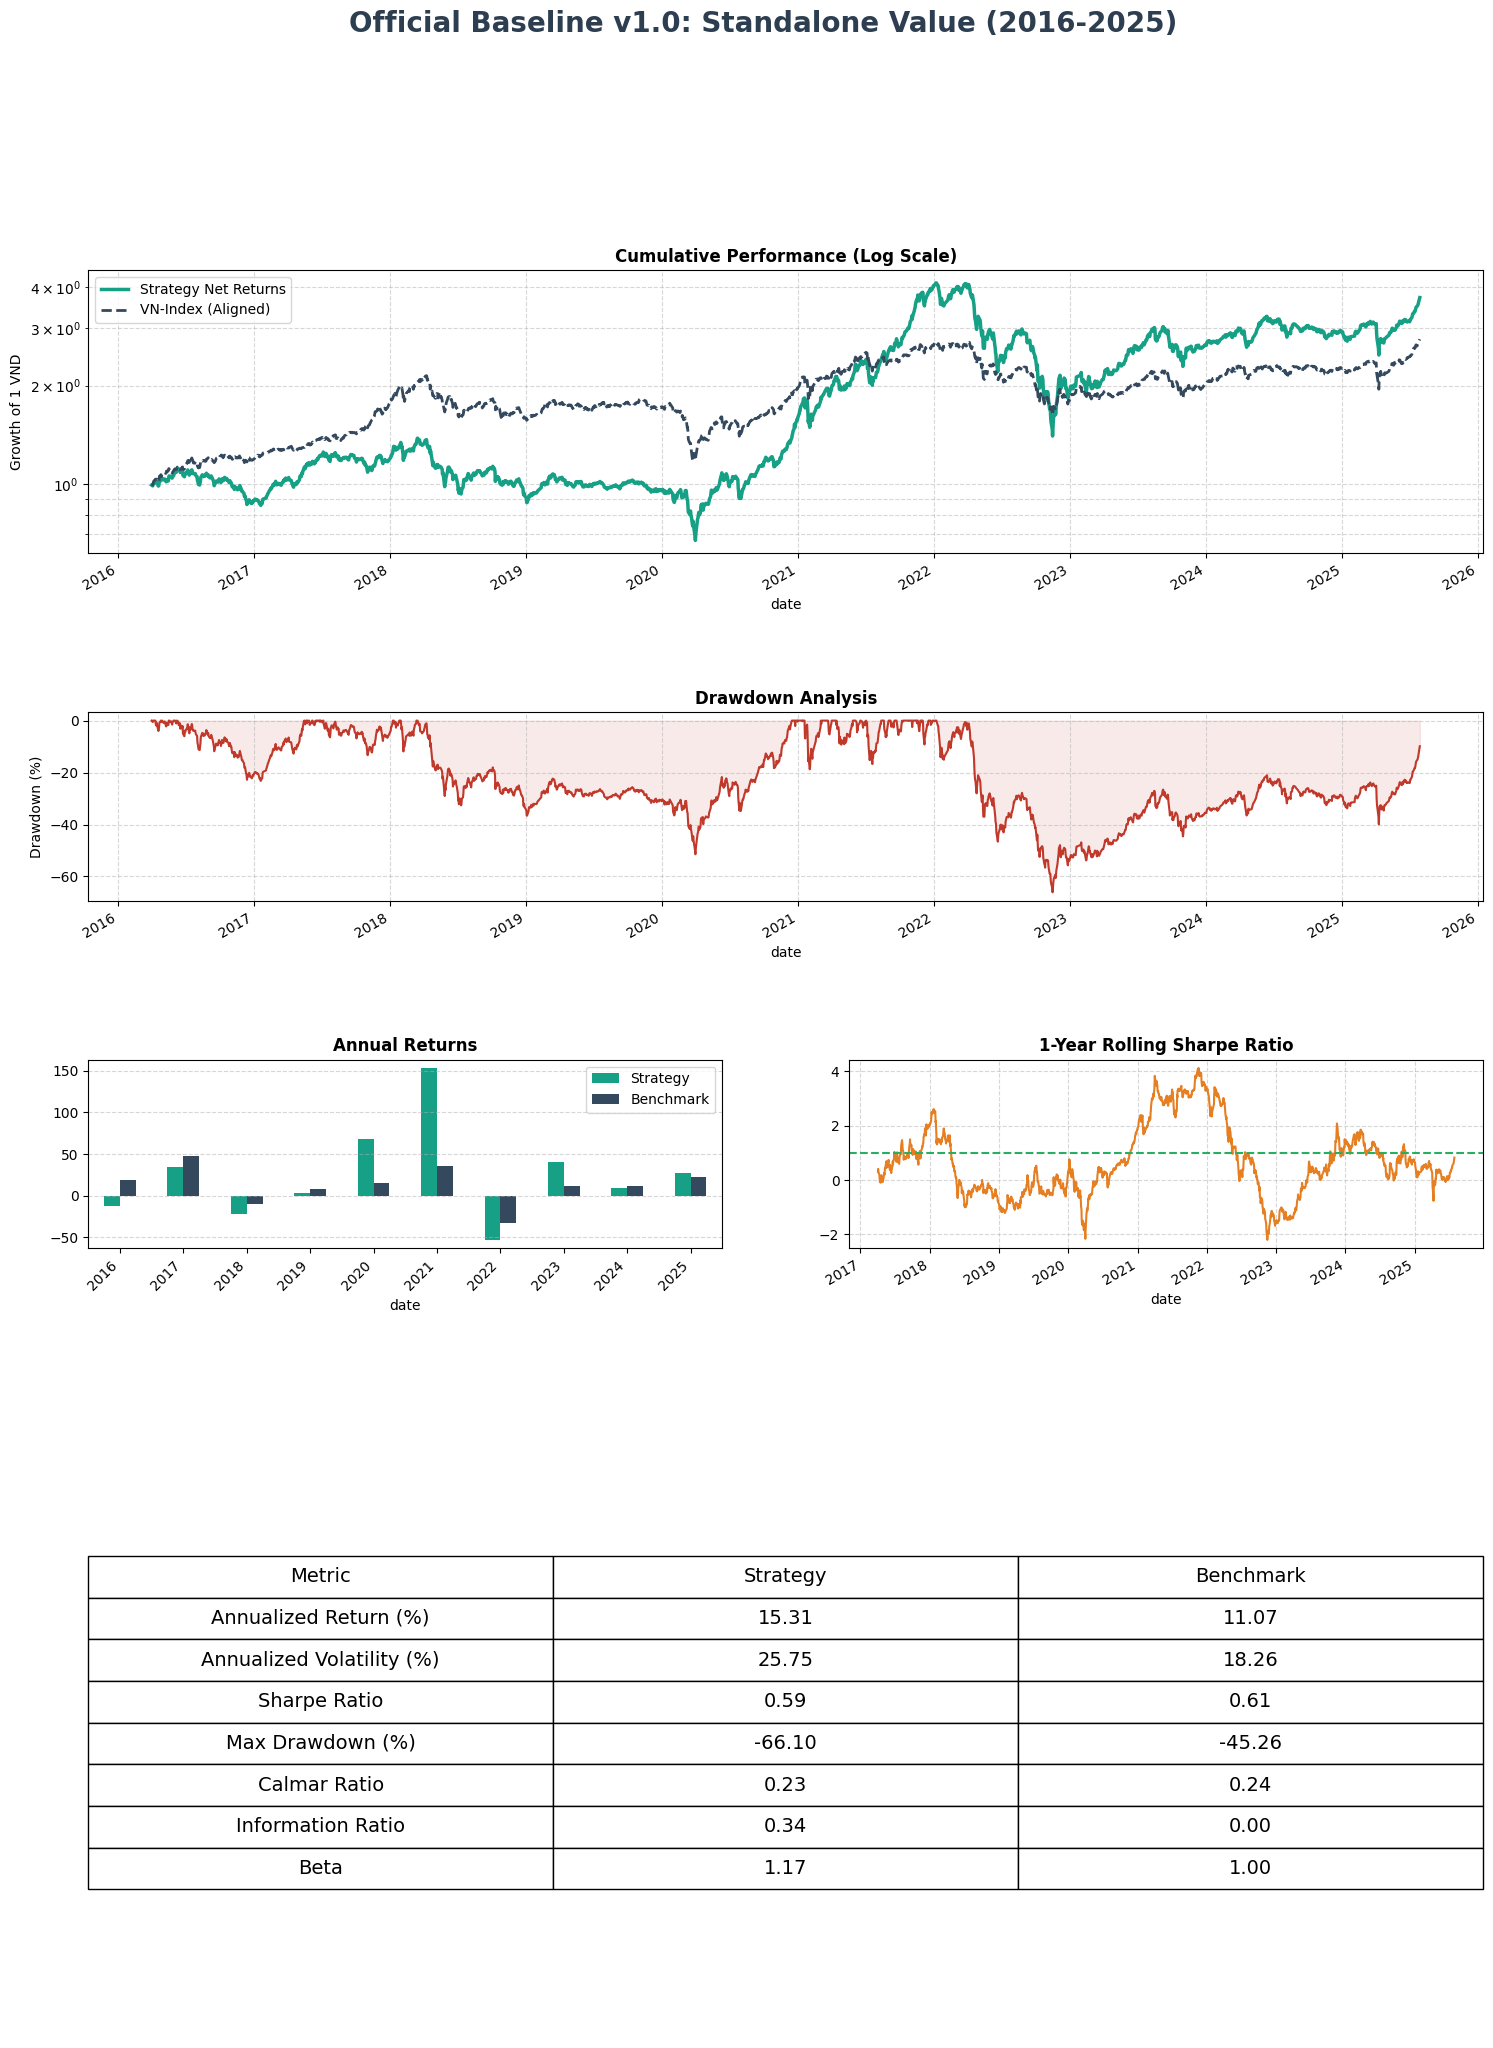

In [5]:
# ============================================================================
# CELL 5: EXECUTION & OFFICIAL BASELINE REPORTING (FULL TEARSHEET)
# ============================================================================

# --- Analytics Suite with Corrected Benchmark Alignment & Full Tearsheet ---
def calculate_official_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    """Calculates a dictionary of institutional performance metrics with corrected alignment."""
    # --- CRITICAL FIX: ALIGN BENCHMARK ---
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date):
        return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    
    aligned_returns = returns.loc[first_trade_date:]
    aligned_benchmark = benchmark.loc[first_trade_date:]
    # --- END FIX ---

    n_years = len(aligned_returns) / periods_per_year
    annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    
    cumulative_returns = (1 + aligned_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    
    excess_returns = aligned_returns - aligned_benchmark
    information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    
    return {
        'Annualized Return (%)': annualized_return * 100,
        'Annualized Volatility (%)': annualized_volatility * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio,
        'Information Ratio': information_ratio,
        'Beta': beta
    }

def generate_official_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str):
    """Generates the full, multi-plot institutional tearsheet with a correctly aligned benchmark."""
    
    # --- CRITICAL FIX: ALIGN BENCHMARK FOR PLOTTING & METRICS ---
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min()
    aligned_strategy_returns = strategy_returns.loc[first_trade_date:]
    aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]
    # --- END FIX ---

    strategy_metrics = calculate_official_metrics(strategy_returns, benchmark_returns)
    benchmark_metrics = calculate_official_metrics(benchmark_returns, benchmark_returns) # Benchmark vs itself
    
    fig = plt.figure(figsize=(18, 26))
    gs = fig.add_gridspec(5, 2, height_ratios=[1.2, 0.8, 0.8, 0.8, 1.2], hspace=0.7, wspace=0.2)
    fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')

    # 1. Cumulative Performance
    ax1 = fig.add_subplot(gs[0, :])
    (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='Strategy Net Returns', color='#16A085', lw=2.5)
    (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2)
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # 2. Drawdown
    ax2 = fig.add_subplot(gs[1, :])
    drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100
    drawdown.plot(ax=ax2, color='#C0392B'); ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1)
    ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)

    # 3. Annual Returns
    ax3 = fig.add_subplot(gs[2, 0])
    strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100
    pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E'])
    ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)

    # 4. Rolling Sharpe Ratio
    ax4 = fig.add_subplot(gs[2, 1])
    rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe.plot(ax=ax4, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5)

    # 5. Metrics Table
    ax5 = fig.add_subplot(gs[3:, :]); ax5.axis('off')
    summary_data = [['Metric', 'Strategy', 'Benchmark']]
    for key in strategy_metrics.keys():
        summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center')
    table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

# --- Instantiate and Run the Baseline Engine ---
try:
    baseline_engine = BaselinePortfolioEngine(
        config=BASELINE_CONFIG,
        factor_data=factor_data_raw,
        returns_matrix=daily_returns_matrix,
        benchmark_returns=benchmark_returns,
        db_engine=engine
    )
    
    baseline_net_returns, baseline_diagnostics = baseline_engine.run_backtest()

    # --- Generate the Official Report ---
    print("\n" + "="*80)
    print("📊 OFFICIAL BASELINE V1.0: PERFORMANCE REPORT")
    print("="*80)
    generate_official_tearsheet(
        baseline_net_returns,
        benchmark_returns,
        baseline_diagnostics,
        "Official Baseline v1.0: Standalone Value (2016-2025)"
    )

except Exception as e:
    print(f"❌ An error occurred during the baseline execution: {e}")
    raise